# Decision tree classifier

In [65]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [64]:
!pip install scikit-learn

In [142]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [144]:
dtc = DecisionTree()
data = datasets.load_breast_cancer()
X, y = data.data, data.target
X_train, y_train, X_test, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=1234)
dtc.fit(X_train, X_test)
predictions = dtc.predict(y_train)

def accuracy(y_test, y_pred):
  return np.sum(y_test == y_pred)/len(y_test)

acc = accuracy(y_test, predictions)
print(acc)

0.9122807017543859


# Decision tree regressor

In [279]:
traindata = pd.read_csv("train_set_CarMarketPlace.csv")
testdata = pd.read_csv("test_set_CarMarketPlace.csv")

In [280]:
# Node Class
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


# Decision Tree Regressor Class
class DecisionTreeRegressor:
    def __init__(self, n_feats = None, max_depth = 100, min_samples_split = 2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None ,
                 random_state=None ,max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0):

        self.root = None
        self.n_feats = n_feats
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, Y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.col = list(X.columns)
        self.root = self.growTree(X, Y)

    def growTree(self, X, Y, depth = 0):

        df = X.copy()
        df['y'] = Y

        ymean = np.mean(Y)

        self.mse = self.get_mse(Y, ymean)

        n_sample, n_feature = X.shape

        # stopping criteria
        if (depth >= self.max_depth or n_sample <= self.min_samples_split):
            leaf_value = np.mean(Y)
            return Node(value=leaf_value)

        feats_idxs = list(X.columns)

        best_feat, best_thresh = self.best_criteria(X, Y, feats_idxs)

        left_df, right_df = df[df[best_feat]<=best_thresh].copy(), df[df[best_feat]>best_thresh].copy()

        left = self.growTree(left_df.drop('y', axis=1), left_df['y'].values.tolist(), depth+1)
        right = self.growTree(right_df.drop('y', axis=1), right_df['y'].values.tolist(), depth+1)

        return Node(best_feat, best_thresh, left, right)


    # find out best criteria
    def best_criteria(self, X, Y, feats_idxs):

        df = X.copy()

        df['y'] = Y

        mse_base = self.mse

        best_feature = None
        best_thresh = None

        for feat in feats_idxs:

            xdf = df.sort_values(feat)

            x_mean = self.moving_average(xdf[feat], 2)

            for value in x_mean:
                left_y = xdf[xdf[feat] < value]['y'].values
                right_y = xdf[xdf[feat] >= value]['y'].values

                left_mean = 0
                right_mean = 0
                if len(left_y) > 0:
                    left_mean = np.mean(left_y)
                if len(right_y) > 0:
                    right_mean = np.mean(right_y)

                res_left = left_y - left_mean
                res_right = right_y - right_mean

                r = np.concatenate((res_left, res_right), axis=None)

                n = len(r)

                r = r ** 2
                r = np.sum(r)
                mse_split = r / n

                if mse_split < mse_base:
                    mse_base = mse_split
                    best_feature = feat
                    best_thresh = value

        return (best_feature, best_thresh)

    def get_mse(self, y_true, y_hat):
        n = len(y_true)

        r = y_true - y_hat

        r = r ** 2

        r = np.sum(r)

        return r / n

    def moving_average(self, x:np.array, window : int):
        return np.convolve(x, np.ones(window), 'valid') / window

    def predict(self, X):
        X = X.to_numpy().tolist()

        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, x, node):

        if node.value is not None:
            return node.value

        fr = node.feature
        index = self.col.index(fr)

        if x[index] <= node.threshold:
            return self.traverse_tree(x, node.left)

        return self.traverse_tree(x, node.right)

In [281]:
import numpy as np
import pandas as pd

In [282]:
traindata.shape, testdata.shape

((6324, 11), (1582, 11))

In [283]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6324 entries, 0 to 6323
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           6320 non-null   object 
 1   Model             6320 non-null   float64
 2   Odometer reading  6320 non-null   float64
 3   fuel              6320 non-null   object 
 4   transmission      6320 non-null   object 
 5   owner             6320 non-null   object 
 6   mileage           6320 non-null   float64
 7   engine            6320 non-null   float64
 8   max_power         6320 non-null   float64
 9   seats             6320 non-null   float64
 10  Price             6320 non-null   float64
dtypes: float64(7), object(4)
memory usage: 543.6+ KB


In [284]:
traindata.isnull().sum()

Company             4
Model               4
Odometer reading    4
fuel                4
transmission        4
owner               4
mileage             4
engine              4
max_power           4
seats               4
Price               4
dtype: int64

In [285]:
traindata.drop_duplicates(inplace=True)
testdata.drop_duplicates(inplace=True)
#print(traindata[traindata.isna().any(axis=1)].index)
traindata = traindata.dropna(how='any')

#print(testdata[testdata.isna().any(axis=1)].index)
testdata = testdata.dropna(how='any')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
print(traindata.info())
print(testdata.info())

for column in ["Company", "fuel", "transmission", "owner"]:
  traindata.loc[:, column] = label_encoder.fit_transform(traindata.loc[:, column])
  traindata[column] = traindata[column].astype(float)
  testdata.loc[:, column] = label_encoder.fit_transform(testdata.loc[:, column])
  testdata[column] = testdata[column].astype(float)
  # traindata.loc[:, column] = pd.get_dummies(traindata.loc[:, column])
  # testdata.loc[:, column] = pd.get_dummies(testdata.loc[:, column])

<class 'pandas.core.frame.DataFrame'>
Index: 5459 entries, 0 to 6323
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           5459 non-null   object 
 1   Model             5459 non-null   float64
 2   Odometer reading  5459 non-null   float64
 3   fuel              5459 non-null   object 
 4   transmission      5459 non-null   object 
 5   owner             5459 non-null   object 
 6   mileage           5459 non-null   float64
 7   engine            5459 non-null   float64
 8   max_power         5459 non-null   float64
 9   seats             5459 non-null   float64
 10  Price             5459 non-null   float64
dtypes: float64(7), object(4)
memory usage: 511.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1581
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1459 non-

In [286]:
# traindata.info()
print(traindata.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5459 entries, 0 to 6323
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           5459 non-null   float64
 1   Model             5459 non-null   float64
 2   Odometer reading  5459 non-null   float64
 3   fuel              5459 non-null   float64
 4   transmission      5459 non-null   float64
 5   owner             5459 non-null   float64
 6   mileage           5459 non-null   float64
 7   engine            5459 non-null   float64
 8   max_power         5459 non-null   float64
 9   seats             5459 non-null   float64
 10  Price             5459 non-null   float64
dtypes: float64(11)
memory usage: 511.8 KB
None


In [287]:
dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=20)

print(testdata.iloc[:, :-1])
dtr.fit(traindata.drop(columns=["Price"]), traindata["Price"])
predictions = dtr.predict(testdata.drop(columns=["Price"]))

from sklearn.metrics import mean_absolute_error, mean_squared_error

      Company   Model  Odometer reading  fuel  transmission  owner  mileage  \
0        26.0  2014.0           84000.0   1.0           1.0    2.0    20.14   
1        22.0  2018.0           18000.0   1.0           1.0    0.0    19.60   
2        18.0  2017.0           37000.0   1.0           0.0    0.0    26.80   
3        25.0  2014.0          120000.0   1.0           1.0    0.0    12.99   
4        18.0  2016.0           45000.0   3.0           1.0    0.0    21.40   
...       ...     ...               ...   ...           ...    ...      ...   
1577      0.0  2014.0          230000.0   1.0           0.0    0.0    15.73   
1578      7.0  2018.0           33360.0   1.0           1.0    0.0    22.77   
1579      9.0  2017.0           54000.0   1.0           1.0    0.0    22.54   
1580     18.0  2010.0          120000.0   3.0           1.0    3.0    19.70   
1581     24.0  2006.0           74000.0   1.0           1.0    0.0    13.70   

      engine  max_power  seats  
0     1498.0      

In [289]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(testdata["Price"].to_numpy(), predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = dtr.get_mse(testdata["Price"].to_numpy(), predictions)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 106986.91934400646
Mean Squared Error (MSE): 57732749272.67177


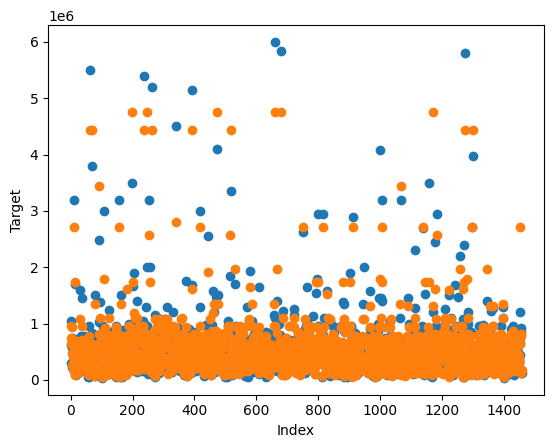

In [291]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(len(testdata)), testdata["Price"].to_numpy())
plt.scatter(np.arange(len(testdata)), predictions)
plt.xlabel("Index")
plt.ylabel("Target")
plt.show()

In [293]:
print(np.mean(predictions), np.mean(testdata["Price"].to_numpy()))

555062.212328347 559816.9712131597
